## **PCA and K-Means + DBSCAN for Stock Market Pairs Trading Selection**

##### Contributors: Jerry Loh, Lian Kah Seng

In this project, we attempt to search for pairs of securities suitable for a mean-reversion pairs trading strategy using machine learning methods. In particular, we apply dimensionality reduction and clustering techniques to historical daily price data for a set of ETFS. 




In [2]:
import os
import glob
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN

'''Importing the data'''

def get_paths(fpath, extension=""):
    '''
    returns dictionary of {stock_name:path_to_csv}
    '''
    all_files = glob.glob(fpath + f"/*{extension}") # get all paths in etf_data 
    return {os.path.basename(v):v for v in all_files}

def get_dataframes(fpath=os.getcwd()+"/etf_data/", start_date="2010-01-01", end_date="2020-01-01"):
    start_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

    paths = get_paths(fpath)
        
    df_list = []
    for symbol, path in paths.items():
        df = pd.read_csv(path, parse_dates=["Date"])
        if df["Date"].iloc[0] >= start_dt or df["Date"].iloc[-1] <= end_dt: # make sure our time series is in the date range
            continue
        else:
            df = df.set_index("Date", drop=True) # set date column as datetimeindex
            df[symbol] = np.log(df["Close"]/df["Close"].shift(1)) # calculate daily logarithmic return and name the column by symbol
            log_returns = df[symbol]
            log_returns = log_returns[start_dt:end_dt] # filter the datetimeindex to the specified date range 
            log_returns = log_returns.dropna() # drop nans
            df_list.append(log_returns)

    return df_list

df_list = get_dataframes()
print(len(df_list))
print("Example dataframe of logarithimic returns:\n", df_list[0])

741
Example dataframe of logarithimic returns:
 Date
2010-01-04    0.032851
2010-01-05    0.009807
2010-01-06    0.023330
2010-01-07   -0.004222
2010-01-08    0.014150
                ...   
2019-12-24    0.031553
2019-12-26    0.014532
2019-12-27   -0.006708
2019-12-30    0.020337
2019-12-31   -0.005918
Name: GDX, Length: 2516, dtype: float64


In [3]:
'''
1. Concatenate the list of dataframes along columns (axis=1) 
2. Take the transpose, where each date is a column/feature
'''

cat = pd.concat(df_list,axis=1)
cat_T = cat.transpose()
cat_T = cat_T.dropna()

print("Concatenated dataframe along columns:\n", cat.iloc[:5,:5]) 
print("\nTaking the transpose:\n", cat_T.iloc[:5,:5])
print("\nDimension of cat_T:", cat_T.shape)


Concatenated dataframe along columns:
                  GDX       DXD       AGG       LTL       BRF
Date                                                        
2010-01-04  0.032851 -0.031028  0.000929  0.049662  0.023530
2010-01-05  0.009807  0.002801  0.004764  0.011958 -0.008553
2010-01-06  0.023330 -0.001400 -0.000528 -0.035576  0.005600
2010-01-07 -0.004222 -0.007372 -0.001057 -0.006405 -0.012230
2010-01-08  0.014150 -0.001762  0.001189 -0.014376  0.012558

Taking the transpose:
 Date  2010-01-04  2010-01-05  2010-01-06  2010-01-07  2010-01-08
GDX     0.032851    0.009807    0.023330   -0.004222    0.014150
DXD    -0.031028    0.002801   -0.001400   -0.007372   -0.001762
AGG     0.000929    0.004764   -0.000528   -0.001057    0.001189
BRF     0.023530   -0.008553    0.005600   -0.012230    0.012558
FXI     0.021547    0.019881    0.011143   -0.015088    0.002733

Dimension of cat_T: (474, 2516)


In [4]:
'''
Feature Scaling: 
- Standardisation is better for this dataset: 
    - We have unbounded numerical values
    - One of the common assumptions in quantitative is log-normal distribution of prices, 
    which implies normal distribution of logarithmic returns

- cat_T.values returns a np.array of log returns
- We will standardise these log returns using StandardScaler
'''

norm = StandardScaler().fit_transform(cat_T.values)
norm_symbols = cat_T.index

print("Values before standardisation:\n", cat_T.values[:3])
print("\nValues after standardisation:\n", norm[:3])

Values before standardisation:
 [[ 3.28509447e-02  9.80735424e-03  2.33299051e-02 ... -6.70788040e-03
   2.03373068e-02 -5.91820700e-03]
 [-3.10282759e-02  2.80118535e-03 -1.39961185e-03 ... -1.79179406e-03
   1.24756564e-02 -4.43774581e-03]
 [ 9.28936435e-04  4.76380417e-03 -5.28192274e-04 ...  1.29545683e-03
   9.24684452e-05 -2.31428013e-03]]

Values after standardisation:
 [[ 0.80384758  0.66968825  2.10728594 ... -1.2234527   3.85440011
  -1.3524834 ]
 [-2.10787365 -0.04284209 -0.46525189 ... -0.30056013  2.54449666
  -1.1019696 ]
 [-0.65121071  0.15675707 -0.37460071 ...  0.27900678  0.48121739
  -0.74265084]]


In [5]:
'''
Dimensionality Reduction with PCA before we apply any clustering algos: 
'''

def pca(norm, symbols, n):
    pca = PCA(n_components=n)
    components = pca.fit_transform(norm)

    print(f"{n} largest eigenvectors of the covariance matrix:\n{pca.explained_variance_}")
    print(f"Percentage of variance explained by each component:\n{pca.explained_variance_ratio_}")
    print(f"Total percentage variance explained: {round(sum(pca.explained_variance_ratio_),3)}\n")

    pca_df = pd.DataFrame(components, columns=[f"PC{k}" for k in range(1,n+1)],index=symbols)
    return pca_df

pca_df = pca(norm, norm_symbols, n=2)
print(pca_df)

2 largest eigenvectors of the covariance matrix:
[785.91842604 256.29278827]
Percentage of variance explained by each component:
[0.31170921 0.10165027]
Total percentage variance explained: 0.413

            PC1        PC2
GDX    1.157984  58.951754
DXD   69.257198  15.310023
AGG   22.884442   2.835303
BRF  -16.012482  23.024830
FXI  -18.057002   8.273340
...         ...        ...
PHO  -10.607866  -7.327142
IJS  -13.300992 -11.040156
AAXJ -12.545235   6.322659
XHB  -12.878668 -14.002795
PBS   -9.144923 -10.574295

[474 rows x 2 columns]


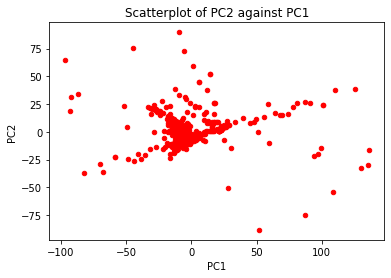

In [6]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots()
pca_df.plot(x="PC1", y="PC2", kind="scatter", 
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
#for k, _ in pca_df.iterrows():
#    ax.annotate(k,_)
plt.show()


In [7]:
'''
make a pointer to store clustering results
'''

cluster_results = {}

Number of datapoints = 474


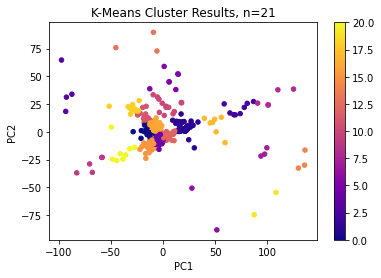

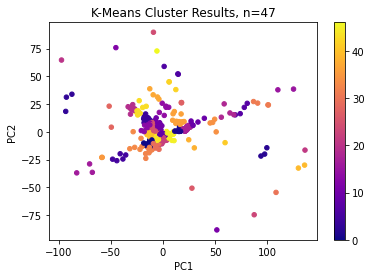

In [8]:
'''
K-Means Clustering
'''

def cluster_kmeans(pca_df, n):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(pca_df)
    results = kmeans.predict(pca_df)

    # plot cluster results
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, n={n}", c=results, cmap="plasma", ax=ax)
    plt.show()
    #pca_df["Cluster"] = y_kmeans
    return results


num_datapoints = len(pca_df)
print(f"Number of datapoints = {num_datapoints}")

sqrt_num_datapoints = int(num_datapoints**0.5)
kmeans_results_sqrt_n = cluster_kmeans(pca_df,n=sqrt_num_datapoints)

_10_percent_datapoints = int(0.1*num_datapoints)
kmeans_results_10_n = cluster_kmeans(pca_df,n=_10_percent_datapoints)

cluster_results[f"KMeans n={sqrt_num_datapoints}"] = kmeans_results_sqrt_n
cluster_results[f"KMeans n={_10_percent_datapoints}"] = kmeans_results_10_n


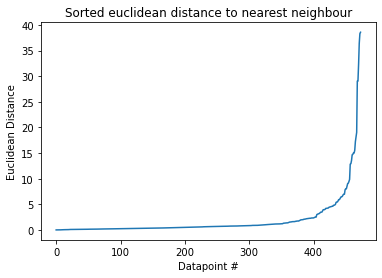

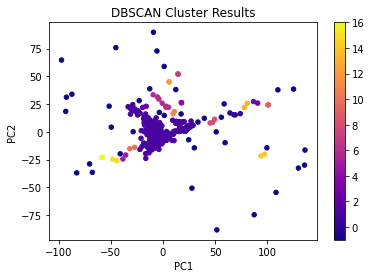

Number of Clusters: 16


In [9]:
'''
DBSCAN Clustering:
'''

def optimise_epsilon(pca_df):
    '''
    Elbow method to find optimal value of epsilon
    '''
    neigh = NearestNeighbors(n_neighbors=2) # find pa
    nbrs = neigh.fit(pca_df)
    distances = nbrs.kneighbors(pca_df)[0]
    distances = np.sort(distances,axis=0) # sort distances row-wise
    distances = distances[:,1:] # remove the 0 value (euclidean distance to itself)

    plt.plot(distances)
    plt.title("Sorted euclidean distance to nearest neighbour")
    plt.xlabel("Datapoint #")
    plt.ylabel("Euclidean Distance")
    plt.show()    

def cluster_dbscan(pca_df, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    #dbscan.fit(pca_df)
    results = dbscan.fit_predict(pca_df)
    
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="plasma", ax=ax)
    plt.show()

    num_clusters = np.max(results) # get number of clusters
    print(f"Number of Clusters: {num_clusters}")

    return results

optimise_epsilon(pca_df) # from the graph, 5 is near elbow point
results = cluster_dbscan(pca_df, eps=5, min_samples=2)

cluster_results["DBSCAN"] = results


In [10]:
'''
Evaluating cluster results:

1. First, we need to map the cluster ids to the symbols of our stocks to get groups of stocks
2. Then
'''

print(norm_symbols.shape) # array of the symbols of stocks
print([x.shape for x in cluster_results.values()]) # contains cluster group assignments for each algorithm

def map_clusters(cluster_result):
    grouping = [[] for _ in range(max(cluster_result)+1)]
    for i, res in enumerate(cluster_result):
        grouping[res].append(norm_symbols[i])
    
    grouping = [g for g in grouping if 1<len(g)<20]
    
    return grouping

for algorithm, cluster_result in cluster_results.items():
    grouping = map_clusters(cluster_result)
    






(474,)
[(474,), (474,), (474,)]


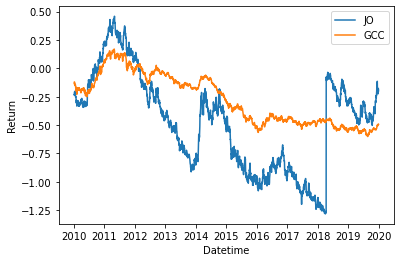

In [12]:
'''
Plot the stock prices of stocks from each cluster
'''

def plot_time_series(group, fpath=os.getcwd()+"/etf_data/", start_date="2010-01-01", end_date="2020-01-01"):
    start_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")
    
    for symbol in group:
        path = fpath+symbol
        df = pd.read_csv(path, parse_dates=["Date"])
        df = df.set_index("Date", drop=True)
        df["LogReturn"] = np.log(df["Close"]/df["Close"].shift(1))
        df["Cumulative Log Return"] = df["LogReturn"].cumsum()

        plt.plot(df["Cumulative Log Return"][start_dt:end_dt])
        plt.xlabel("Datetime")
        plt.ylabel("Return")
    plt.legend(group)
    plt.show()

plot_time_series(grouping[10])


# **Contents**
1. Metric
2. Clustering Techniques Used
    - k-Means Clustering
    - DBScans
    - Hierarchical Clustering
3. Dimensionality Reduction Techniques Used
    - PCA

***
## 1. Metric
***

### **Metric**


* What is the importance of choosing the appropriate **metric**?
     * choosing a different metric will affect the shape of the clusters
     * some data points will be considered to be closer to one another under one metric as compared to another
<br/> 
<br/> 
* **Commonly used** metrics
<br/> 
*assuming $a$ and $b$ are two data points in a given dataset and there are a total of p feature variables/attributes,
we denote the distance between the two data points to be $||a-b||$*
<br/>
*the metrics are as follows:*
<br/>
<br/>  
     * Euclidean distance
     <br/> 
     <br/> 
     $||a-b|| = \sqrt { \sum_{i=1}^p (a_i-b_i)^2 } $
     <br/> 
     <br/>
     * Squared Euclidean distance
     <br/> 
     <br/> 
     $||a-b|| =  \sum_{i=1}^p (a_i-b_i)^2  $
     <br/> 
     <br/>
     * Manhattan distance
     <br/> 
     <br/> 
     $||a-b|| = \sum_{i=1}^p |a_i-b_i|  $
     <br/> 
     <br/>
     * Minkowski distance
     <br/> 
     <br/> 
     $||a-b|| = (\sum_{i=1}^p (a_i-b_i)^p)^\frac{1}{p}  $
     


***
## 2. Clustering Techniques Used
***

### **What is k-Means Clustering?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/>
<br/> 
* Advantages
     * fast and easy to understand & implement
     * time efficient
     * gives best outcome when the data sets are distinct and very far apart from each other
<br/>
<br/> 
* **How does k-Means work?**
     * it is an analytical technique that, for a chosen value of k, identifies k clusters of objects based on the objects’ proximity to the center of the k groups.
     * The center is determined as the arithmetic average (mean) of each cluster’s n-dimensional vector of attributes. 
<br/>
<br/>
* **Metrics**
     * in the case of our k-Means Clustering technique, the formulas used below and the steps discussed will be the use of Euclidean Distance
<br/> 
<br/> 
* **Steps** involved
     1. a k-value is chosen (this determines the number of clusters)
     2. k data points are chosen as the centroids
     3. other data points are assigned/grouped (labeled) to respective centroids (based on whichever centroid they are the closest to)
     <br/> 
     <br/> 
     *for a given data-set of M data points, with p feature variables/attributes such that the *i*-th data point has the coordinates of ($x1_i$,$x2_i$,...$xp_i$)*, 
     <br/> 
     <br/> 
     *for the *Dc*-th centroid chosen, with the coordinates ($x1_{Dc}$,$x2_{Dc}$,...$xp_{Dc}$), the euclidean distance between any given *i*-th data point, where $i \in 1,2,...,M$, and any given *d*-th centroid, where $c \in 1,2,...,k$ is given by*:
     <br/> 
     <br/> 
     $\sqrt{\sum_{j=1}^p (xj_i-xj_{Dc})^2}$
     <br/> 
     <br/> 
     4. after all the data points have been assigned/grouped(labeled), in each cluster, a new centroid coordinate is generated. this is the calculated using the mean of all the coordinates within that particular cluster.
     <br/> 
     *the new centroid for a cluster with z points is given by:*
     <br/> 
     <br/> 
     $(\frac{1}{m} \sum_{i=1}^z x1_i,\frac{1}{m} \sum_{i=1}^z x2_i,...,\frac{1}{m} \sum_{i=1}^z xp_i)$
     <br/> 
     <br/> 
     5. steps 3 and 4 are then repeated till convergence *(this can be done either through setting a limit on the number of recursions or by repeating until the coordinates centroids only change by a small amount (0.01), or until the data points stay within the same cluster for a few repetitions)*
<br/> 
<br/> 
* More pointers
     1. the k-value can be chosen via a variety of techniques, one way is through Within Sum of Squares (WSS).
     2. for each centroid, the sum of squared distances from each of the points within the cluster is calculated  
     3. these values are then summed up together and plotted onto a graph
     <br/> 
     <br/> 
     *for a data set with M points and p feature variables/attributes, the WSS is calculated via:*   
     <br/> 
     $\sum_{i=1}^M \sum_{j=1}^p (xj_i-xj_{Dc})^2$
     <br/>
     <br/>
     *given that the *D*-th centroid has the coordinates ($x1_{Dc}$,$x2_{Dc}$,...$xp_{Dc}$)* 
<br/>
<br/>
* **Limitations**
     1. requires specification of the number of cluster
     2. unable to handle outliers and noisy data
     3. cannot be used for categorical data

### **What is DBSCAN?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/> 
<br/> 
* Advantages
     * does not require one to specify number of clusters
     * able to identify noisy data during clustering
     * able to find find arbitrarily sized & arbitrarily shaped clusters
<br/> 
<br/> 
* Definitions
     1. Firstly, ε-neighborhood. The ε-neighborhood of a point, $q$, is defined as:
     <br/>
     <br/>
     $N_\varepsilon(q) = \{p \in X|d(q,p) \leq \varepsilon \}$
     <br/>
     <br/>
     2. Corepoint: A point q is core point if it verifies 
     <br/>
     <br/>
     $|N_\varepsilon(q)| \geq minPts$
     <br/>
     <br/>
     where $|N_\varepsilon(q)|$ the number of points within the ε-neighborhood of $q$. $minPts$ accounts for the point itself.
     <br/>
     <br/>
     3. Directly density-reachable: Point p is directly density-reachable from point $q$ in a set of points $X$ provided that $p \in N_\varepsilon(q)$ and $q$ is a core point.
     4. Density-reachable: A point $p$ is density-reachable from a point $q$ if there is a chain of objects $p_1,..., p_n$, where $p_1 = q$ and $p_n = p$ such that $p_{i+1}$ is directly density-reachable from $p_i$ .
     5. Density-connected: A point $p$ is density-connected to a point $q$ if both points are density-reachable from a common core point.
     <br/>
     <br/>
* **How does DBScans work?**
     * given the definitions above, DBScans also work based on clustering. However a cluster in the case of DBScans fulfills two properties: All points within a cluster are mutually density-connected and (ii) if a point is density-reachable from any point of the cluster, it must belong to the cluster.
     * DBScans is different in the sense that not all points will belong to a cluster at the end of the process. If a point does not belong to any cluster, it is considered noise
<br/>
<br/>
* **Steps** involved
     1. Find the points in the ε-neighborhood of every point and identify the core points with more than $minPts$ neighbours.
     2. Find the connected components of core points on the neighbour graph, ignoring all non-core points.
     3. Assign each non-core point to a nearby cluster if the cluster is an ε-neighbor, otherwise assign it to noise.
<br/>
<br/>
* **Limitations**
     1. very sensitive to its parameters, namely the definition of $\varepsilon$
     2. the clusters are assumed to be evenly densed, which means the clusters that are formed will also be evenly densed (no variance in cluster density)
     3. for a given $\varepsilon$, it might work well for a cluster of a given denstiy but not as much for another cluster with a different density in the same dataset

### **What is Hierarchical Clustering?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/> 
<br/> 
* Advantages
     * results in a dendrogram, a tree that showcases the well-defined hierachy
     * no need to pre-specify number of clusters (can obtain any desired number of clusters by cutting the Dendrogram at the proper level)
<br/> 
<br/> 
* **How does Hierarchical Clustering work?**
     * there are two approaches to hierarchical clustering, mainly **Agglomerative** and **Divisive**
          * Agglomerative is a "bottom-up" approach where each data point is treated as its own cluster. Then an iterative process begins where pairs of clusters (that have identified to be the closest together / most similar) are merged (as it moves up the hierarchy).
          * Divisive is a "top-down" approach where every single data point is first identified to be in one singular cluster. Then, an iterative processs begins where splits in the cluster are performed (as it moves down the hierarchy, based on a distance metric).
<br/>
<br/>
* **Steps** involved (Agglomerative)
     1. First, treat each data point as its own cluster, which will result in the formation of N clusters (Assuming there are a total of N data points)
     2. Take two closest data points and make them one cluster; this results in a total of N-1 clusters
     3. Step 2 is repeated until there is only one large cluster left
     4. Now, the order at which the clusters are formed (the hierarchy) results in the production of a dendrogram
<br/>
<br/>
* What is a **Dendogram**?
     * a diagram that represents the hierarchical relationship between objects
     * used to display the distance between each pair of sequentially merged objects
     * primary use of a dendrogram is to work out the best way to allocate objects to clusters
<br/>
<br/>
* **Limitations**
     1. very sensitive to noise and outliers
     2. faces difficulties in handling clusters of different sizes
     3. ends up breaking large clusters
     4. once a decision is made to combine two clusters (or seperate into two clusters in the case of Divisive), it can't be undone

***
## 3. Dimensionality Reduction Techniques Used
***

### **What is PCA?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/>
<br/> 
* **How does PCA work?**
     * it a dimensionality-reduction method that is used to  reduce dimensionality of large data sets by simplifying data, reducing noise and transforming them into smaller ones (but still containing information in the large set)
     * it can be used prior to k-Means so that computation cost is decreased
<br/> 
<br/> 
* Steps involved
     1. calculate mean for every dimension of the dataset
     2. calculate the covariance matrix of the entire dataset
     <br/>
     <br/>
     *for a data set with M feature variables/attributes with $n$ dimensions, using PCA, the data would be reduced from $n$ dimensions to $k$ dimensions, where $n<k$. covariance is calculated by:*
     <br/>
     <br/>
     $cov(X,Y) = \frac{1}{M-1}\sum_{i=1}^M (X_i - \overline{X})(Y_i - \overline{Y})$
     <br/>
     <br/>
     *in this case though, since it is forming a covariance matrix, the covariance matrix, S would be given by:*
     <br/>
     <br/>
     $S = \frac{1}{M}\sum_{i=1}^M (X_i)(X_i)^T$
     <br/>
     <br/>
     3. compute the eigenvectors and the corresponding eigenvalues
     4. sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a *d x k* dimensional matrix W
     5. using this matrix, transform the samples onto the new subspace